In [2]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt
import Levenshtein

import sys
sys.path.append('..')
from lib import *

from pyrepseq import *
import pyrepseq.plotting as pp
import random

plt.style.use('../peptidome.mplstyle')

In [6]:
k = 9
selfset = set(count_kmers_proteome(human, k, clean=True))

In [3]:
# only human host
df_t = load_iedb_tcellepitopes(human_only=True)
print(df_t.shape[0])

248879


In [4]:
# only MHC I epitopes
df_t = df_t[df_t['MHC', 'Class']=='I']
print(df_t.shape[0])

69747


In [7]:
# only epitopes of length k
mask = df_t['Epitope', 'Description'].apply(len)==k
df_t = df_t[mask]
print(df_t.shape[0])

37813


In [8]:
# no host epitopes
host = 'Homo sapiens'
# can also set na=True to exclude epitopes of unknown provenance
mask = ~df_t['Epitope', 'Parent Species'].str.contains(host, na=True)
df_t = df_t[mask]
print(df_t.shape[0])

30967


In [9]:
# exclude autoimmune / allergy / cancer epitopes
mask = ~(df_t['1st in vivo Process', 'Process Type'].isin(['Occurrence of autoimmune disease', 
                                                           'Occurrence of allergy',
                                                           'Occurrence of cancer']))
df_t = df_t[mask]
print(df_t.shape[0])

30619


In [10]:
# restrict to ELISPOT assay
mask = df_t['Assay', 'Method/Technique'] == 'ELISPOT'
df_t = df_t[mask]
print(df_t.shape[0])

18898


# Keep most frequent qualitative measure

In [9]:
# uniquify epitopes by keeping only the most frequent qualitative measure
def most_frequent(x):
    counts = x.value_counts(dropna=False)
    if len(counts):
        return counts.index[0]
    else:
        print(x, counts)
    return np.nan
d = df_t[[('Epitope', 'Description'), ('Assay', 'Positive')]].groupby(('Epitope', 'Description')).agg(most_frequent)
d = d.reset_index()
len(d)

6455

In [10]:
epitope_counts = df_t.groupby(('Epitope', 'Description')).agg('count')['Reference', 'Assay IRI']
(epitope_counts>1).sum()

np.int64(4193)

In [11]:
positive_fraction = df_t.groupby(('Epitope', 'Description')).agg(np.mean)['Assay', 'Positive']
len(positive_fraction[(positive_fraction>0.0) & (positive_fraction<1.0)])

/scratch/lsftmp/10962746.tmpdir/ipykernel_91819/2047044399.py:1: FutureWarning: The provided callable <function mean at 0x2b26a6e28360> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  positive_fraction = df_t.groupby(('Epitope', 'Description')).agg(np.mean)['Assay', 'Positive']


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
plt.hist(positive_fraction)
plt.yscale('log')
plt.ylim(1e0)

# Keep only unambiguous

In [26]:
d_mean = df_t[[('Epitope', 'Description'),
               ('Assay', 'Positive')]].groupby(('Epitope', 'Description')).agg(np.mean)
print(len(d_mean))
d = d_mean[d_mean['Assay', 'Positive'].isin([0.0, 1.0])]
d = d.reset_index()
len(d)

6455


/scratch/lsftmp/11553107.tmpdir/ipykernel_89899/4276047600.py:2: FutureWarning: The provided callable <function mean at 0x2b0b2fda7a60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ('Assay', 'Positive')]].groupby(('Epitope', 'Description')).agg(np.mean)


6060

In [27]:
d['nndist'] = d['Epitope', 'Description'].apply(lambda x: nndist_hamming(x, selfset, maxdist=3))

In [14]:
d['nndist4'] = d['Epitope', 'Description'].apply(lambda x: nndist_hamming(x, selfset, maxdist=4))

In [28]:
d.columns = d.columns.get_level_values(0)

In [29]:
np.unique(list(df_t[df_t['Epitope', 'Description']=='QYDPVAALF']['Reference', 'Reference IRI']))

array(['http://www.iedb.org/reference/1004633',
       'http://www.iedb.org/reference/1004980',
       'http://www.iedb.org/reference/1005858',
       'http://www.iedb.org/reference/1005885',
       'http://www.iedb.org/reference/1024955',
       'http://www.iedb.org/reference/1028940',
       'http://www.iedb.org/reference/493'], dtype='<U37')

In [29]:
dist1 = d[(d['nndist']==1) & (d['Assay']==1.0)]
for epitope in dist1['Epitope']:
    print(epitope)
    print(np.unique(list(df_t[df_t['Epitope', 'Description']==epitope]['Reference', 'Reference IRI'])))
    one_away = levenshtein_neighbors(epitope)
    for neighbor in one_away:
        if neighbor in selfset:
            print(f"Found: {neighbor}")
    print('-----------------------------------------------')

AEMLREEGY
['http://www.iedb.org/reference/1028103']
Found: AEMIREEGY
-----------------------------------------------
AESRKLLLI
['http://www.iedb.org/reference/1013714']
Found: AESRKLLLR
-----------------------------------------------
AKLDRLDEE
['http://www.iedb.org/reference/1003735']
Found: AKLDNLDEE
-----------------------------------------------
AMAGASTSA
['http://www.iedb.org/reference/1013323']
Found: ASAGASTSA
-----------------------------------------------
APVPPPEPL
['http://www.iedb.org/reference/1005887']
Found: APVVPPEPL
-----------------------------------------------
DLQDRNTEL
['http://www.iedb.org/reference/1030790']
Found: DLQDRNDEL
-----------------------------------------------
EEAIVAYTL
['http://www.iedb.org/reference/1005811']
Found: EEAPVAYTL
-----------------------------------------------
EYVLLLFLL
['http://www.iedb.org/reference/1001605']
Found: EYVLLLFLA
-----------------------------------------------
FLGERVTLT
['http://www.iedb.org/reference/1013203']
Found: FKGER

In [30]:
# random sample to spot check references
for epitope in list(dist1['Epitope']):
    print(epitope)
    print(np.unique(list(df_t[df_t['Epitope', 'Description']==epitope]['Reference', 'Reference IRI'])))
    
    one_away = levenshtein_neighbors(epitope)
    for neighbor in one_away:
        if neighbor in selfset:
            print(f"Found: {neighbor}")
            break
    print('-----------------------------------------------')

AEMLREEGY
['http://www.iedb.org/reference/1028103']
Found: AEMIREEGY
-----------------------------------------------
AESRKLLLI
['http://www.iedb.org/reference/1013714']
Found: AESRKLLLR
-----------------------------------------------
AKLDRLDEE
['http://www.iedb.org/reference/1003735']
Found: AKLDNLDEE
-----------------------------------------------
AMAGASTSA
['http://www.iedb.org/reference/1013323']
Found: ASAGASTSA
-----------------------------------------------
APVPPPEPL
['http://www.iedb.org/reference/1005887']
Found: APVVPPEPL
-----------------------------------------------
DLQDRNTEL
['http://www.iedb.org/reference/1030790']
Found: DLQDRNDEL
-----------------------------------------------
EEAIVAYTL
['http://www.iedb.org/reference/1005811']
Found: EEAPVAYTL
-----------------------------------------------
EYVLLLFLL
['http://www.iedb.org/reference/1001605']
Found: EYVLLLFLA
-----------------------------------------------
FLGERVTLT
['http://www.iedb.org/reference/1013203']
Found: FKGER

In [31]:
df_t[df_t['Epitope', 'Description']=='LIASNVAGV']['Assay Antigen', 'Organism Species Name']

196870    Mycobacterium tuberculosis
Name: (Assay Antigen, Organism Species Name), dtype: object

In [21]:
d.groupby(by=['nndist']).count()[['Epitope']]

,Epitope
nndist,
0,22
1,107
2,2421
3,3510


In [25]:
d.groupby(by=['nndist4','Assay']).count()[['Epitope']]

Epitope
nndist4 Assay         
0       0.0         21
        1.0          1
1       0.0         79
        1.0         28
2       0.0       1799
        1.0        622
3       0.0       2802
        1.0        694
4       0.0          8
        1.0          6

In [19]:
d['Assay']

0       1.0
1       0.0
2       1.0
3       1.0
4       1.0
       ... 
6055    0.0
6056    0.0
6057    0.0
6058    1.0
6059    0.0
Name: Assay, Length: 6060, dtype: float64

In [ ]:
dagg = d.groupby('nndist').agg({'Assay': ['mean', 'count']})
dagg.columns = dagg.columns.get_level_values(1)
ps = np.asarray(list(dagg['mean']))
ns = np.asarray(dagg['count'])
ps, ns


In [ ]:
dagg.to_csv('../../figures/New Paper Figures/Figure Data/response_vs_distance.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(1.5, 1.75))
lower, upper = statsmodels.stats.proportion.proportion_confint(ps*ns, ns, method='jeffreys', alpha=.1)
ax.errorbar(range(len(ps)), ps, yerr=[ps-lower, upper-ps], ls='None', fmt='_')
ax.set_ylim(0.0, 0.47)
ax.set_xlabel('Distance to Self')
ax.set_ylabel('Fraction Immunogenic')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([0, 1, 2, '3+'])
fig.tight_layout()
# fig.savefig(figuredir+'iedbposvsdist.svg')

In [ ]:
test = statsmodels.stats.proportion.proportions_chisquare_allpairs(ps*ns, ns)
list(zip(test.all_pairs, test.pval_corrected()))

In [23]:
df_t['Epitope', 'Description']

9         KLEDLERDL
10        LITGRLQSL
192       FIAGLIAIV
219       QYDPVAALF
468       HSKKKCDEL
            ...    
388154    TYGPVFMCL
388155    RPQKRPSCI
388156    IPQCRLTPL
388157    RPPIFIRRL
388158    QPRAPIRPI
Name: (Epitope, Description), Length: 18898, dtype: object

# Closer look at near matches

In [25]:
whitelist = d[(d['nndist']==1) & (d['Assay']==1)]['Epitope']

In [27]:
df_t[df_t['Epitope', 'Description'].isin(set(whitelist))]['Epitope']

,Epitope IRI,Object Type,Description,Starting Position,Ending Position,Non-peptidic epitope IRI,Antigen Name,Antigen IRI,Parent Protein,Parent Protein IRI,Organism Name,Organism IRI,Parent Species,Parent Species IRI,Epitope Comments,Length
3962,http://www.iedb.org/epitope/21078,Linear peptide,GLPVEYLQV,48.0,56.0,NaN,Antigen 85-A precursor,http://www.ncbi.nlm.nih.gov/protein/P0A4V2.1,sp|P9WQP3|A85A_MYCTU Diacylglycerol acyltransf...,http://www.uniprot.org/uniprot/P9WQP3,Mycobacterium tuberculosis H37Rv,http://purl.obolibrary.org/obo/NCBITaxon_83332,Mycobacterium tuberculosis,http://purl.obolibrary.org/obo/NCBITaxon_1773,NaN,9
3970,http://www.iedb.org/epitope/31902,Linear peptide,KLIANNTRV,242.0,250.0,NaN,Antigen 85-A precursor,http://www.ncbi.nlm.nih.gov/protein/P0A4V2.1,sp|P9WQP3|A85A_MYCTU Diacylglycerol acyltransf...,http://www.uniprot.org/uniprot/P9WQP3,Mycobacterium tuberculosis H37Rv,http://purl.obolibrary.org/obo/NCBITaxon_83332,Mycobacterium tuberculosis,http://purl.obolibrary.org/obo/NCBITaxon_1773,NaN,9
14100,http://www.iedb.org/epitope/15110,Linear peptide,EYVLLLFLL,717.0,725.0,NaN,Genome polyprotein,http://www.ncbi.nlm.nih.gov/protein/P26663.3,sp|P27958|POLG_HCVH Genome polyprotein OS=Hepa...,http://www.uniprot.org/uniprot/P27958,Hepacivirus C,http://purl.obolibrary.org/obo/NCBITaxon_11103,Hepacivirus C,http://purl.obolibrary.org/obo/NCBITaxon_11103,NaN,9
16441,http://www.iedb.org/epitope/37120,Linear peptide,LLCLIFLLV,251.0,259.0,NaN,Major surface antigen precursor,http://www.ncbi.nlm.nih.gov/protein/P17399.3,sp|Q76R62|HBSAG_HBVCJ Large envelope protein O...,http://www.uniprot.org/uniprot/Q76R62,Hepatitis B virus,http://purl.obolibrary.org/obo/NCBITaxon_10407,Hepatitis B virus,http://purl.obolibrary.org/obo/NCBITaxon_10407,NaN,9
16447,http://www.iedb.org/epitope/16751,Linear peptide,FLLSLGIHL,575.0,583.0,NaN,Protein P,http://www.ncbi.nlm.nih.gov/protein/P03159.1,sp|Q69028|DPOL_HBVCJ Protein P OS=Hepatitis B ...,http://www.uniprot.org/uniprot/Q69028,Hepatitis B virus,http://purl.obolibrary.org/obo/NCBITaxon_10407,Hepatitis B virus,http://purl.obolibrary.org/obo/NCBITaxon_10407,NaN,9
61452,http://www.iedb.org/epitope/2231,Linear peptide,AKLDRLDEE,10.0,18.0,NaN,kinetoplastid membrane protein-11 - Leishmania...,http://www.ncbi.nlm.nih.gov/protein/S53442,tr|E9BS96|E9BS96_LEIDB Kinetoplastid membrane ...,http://www.uniprot.org/uniprot/E9BS96,Leishmania donovani,http://purl.obolibrary.org/obo/NCBITaxon_5661,Leishmania donovani,http://purl.obolibrary.org/obo/NCBITaxon_5661,NaN,9
67371,http://www.iedb.org/epitope/11500,Linear peptide,EEAIVAYTL,381.0,389.0,NaN,55 kDa immediate-early protein 1,http://www.ncbi.nlm.nih.gov/protein/P13202.1,sp|F5HCM1|VIE1_HCMVM 55 kDa immediate-early pr...,http://www.uniprot.org/uniprot/F5HCM1,Human betaherpesvirus 5,http://purl.obolibrary.org/obo/NCBITaxon_10359,Human betaherpesvirus 5,http://purl.obolibrary.org/obo/NCBITaxon_10359,NaN,9
67926,http://www.iedb.org/epitope/40710,Linear peptide,LYALALLLL,357.0,365.0,NaN,membrane protein,http://www.ncbi.nlm.nih.gov/protein/AAA45887.1,sp|P13285|LMP2_EBVB9 Latent membrane protein 2...,http://www.uniprot.org/uniprot/P13285,Human gammaherpesvirus 4,http://purl.obolibrary.org/obo/NCBITaxon_10376,Human gammaherpesvirus 4,http://purl.obolibrary.org/obo/NCBITaxon_10376,NaN,9
68392,http://www.iedb.org/epitope/54638,Linear peptide,RLLDRLVRL,50.0,58.0,NaN,nucleoprotein,http://www.ncbi.nlm.nih.gov/protein/ABI54110.1,sp|Q9WMB5|NCAP_MEASC Nucleoprotein OS=Measles ...,http://www.uniprot.org/uniprot/Q9WMB5,Measles virus strain Edmonston,http://purl.obolibrary.org/obo/NCBITaxon_11235,Measles morbillivirus,http://purl.obolibrary.org/obo/NCBITaxon_11234,NaN,9
70150,http://www.iedb.org/epitope/3892,Linear peptide,APVPPPEPL,55.0,63.0,NaN,BLRF2,http://www.ncbi.nlm.nih.gov/protein/ABB89241.1,sp|P03197|BLRF2_EBVB9 Tegument protein BLRF2 O...,http://www.uniprot.org/uniprot/P03197,Human gammaherpesvirus 4,http://purl.obolibrary.org/obo/NCBITaxon_10376,Human gammaherpesvirus

In [28]:
df_d1 = d[d['nndist']==1].copy()

In [30]:
epitopes = df_d1['Epitope']

In [31]:
alleles = [df_t[df_t['Epitope', 'Description'] == epitope]['MHC', 'Allele Name'].agg(most_frequent)
           for epitope in epitopes]

In [32]:
pd.value_counts(alleles).head(10)

/scratch/lsftmp/10384950.tmpdir/ipykernel_72136/310473957.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(alleles).head(10)
/scratch/lsftmp/10384950.tmpdir/ipykernel_72136/310473957.py:1: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.value_counts(alleles).head(10)


HLA-A*02:01    30
HLA-B*37:01    13
HLA-A*23:01    12
HLA-A*03:01    11
HLA-A*01:01     7
HLA class I     6
HLA-B*07:02     5
HLA-A2          4
HLA-B*44:02     3
HLA-A*24:02     3
Name: count, dtype: int64

In [33]:
neighbors = []
neighbor_numbers = []
diffposs = []
for epitope in epitopes:
    all_neighbors = set(hamming_neighbors(epitope)).intersection(selfset)
    neighbor = random.choice(list(all_neighbors))
    diffpos = int(np.where(np.array(list(epitope)) != np.array(list(neighbor)))[0])
    diffposs.append(diffpos)
    neighbors.append(all_neighbors)
    neighbor_numbers.append(len(all_neighbors))
    #print(epitope,
    #      neighbor,
    #      len(all_neighbors),
    #      diffpos)
neighbor_numbers = np.array(neighbor_numbers)
neighbors = np.array(neighbors)
diffposs = np.array(diffposs)

/scratch/lsftmp/10384950.tmpdir/ipykernel_72136/4138207079.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diffpos = int(np.where(np.array(list(epitope)) != np.array(list(neighbor)))[0])


In [34]:
df_d1['Position difference'] = diffposs
df_d1['Neighbors'] = neighbor_numbers>1.0

In [35]:
anchors = [1, 8]
tcem = [0, 2, 3, 4, 5, 6, 7]

In [ ]:
ps = df_d1.groupby('Position difference').agg('mean')['Assay', 'Positive']
ns = df_d1.groupby('Position difference').agg('count')['Assay', 'Positive']
npos = ns*ps
npos_coarse = np.array([npos.loc[tcem].sum(), npos.loc[anchors].sum()])
n_coarse = np.array([ns.loc[tcem].sum(), ns.loc[anchors].sum()])
ps_coarse = npos_coarse/n_coarse
lower, upper = statsmodels.stats.proportion.proportion_confint(npos_coarse, n_coarse, method='jeffrey', alpha=.1)
fig, ax = plt.subplots(figsize=(1.25, 1.75))
ax.errorbar(['False', 'True'], ps_coarse, yerr=[ps_coarse-lower, upper-ps_coarse], ls='None', fmt='_')
ax.set_ylim(0, 0.6)
ax.set_xlim(-0.25, 1.25)
ax.set_ylabel('Fraction immunogenic')
ax.set_xlabel('Anchor Substitution')
fig.tight_layout()
fig.savefig(figuredir+'iedb_anchor_vs_tcem.svg')

In [ ]:
test = statsmodels.stats.proportion.proportions_chisquare(npos_coarse, n_coarse)
test[1]

Text(0.5, 0, 'Neighbor number')

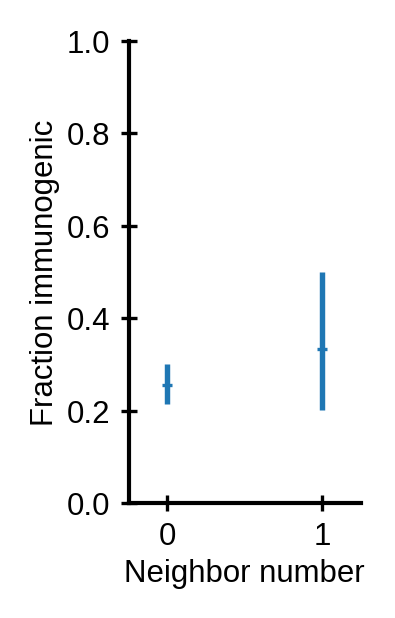

In [28]:
ps = df_d1.groupby('Neighbors').agg('mean')['Assay', 'Positive']
ns = df_d1.groupby('Neighbors').agg('count')['Assay', 'Positive']
npos = ns*ps
lower, upper = statsmodels.stats.proportion.proportion_confint(npos, ns, method='jeffreys', alpha=1-.68)
fig, ax = plt.subplots(figsize=(1.0, 2))
ax.errorbar(ns.index, ps, yerr=[ps-lower, upper-ps], ls='None', fmt='_')
ax.set_ylim(0, 1.0)
ax.set_xlim(-0.25, 1.25)
ax.set_ylabel('Fraction immunogenic')
ax.set_xlabel('Neighbor number')

# Epitope Distance

In [37]:
# sys.path.append('/home/andreas/drop/projects_ongoing/zach_andreas/code/EpitopeDistance/epdist')
# sys.path
# from EpitopeDistance import EpitopeDistance
sys.path.append('/data/lareauc/levinej/pep/CFIT')
from cfit.fitness.neo_quality.EpitopeDistance import EpitopeDistance
epidist = EpitopeDistance(model_name='all_tcr_all_combos_model')
def dist(epiA,epiB):
    return sum(
    [epidist.d_i[i] * epidist.M_ab[epidist.amino_acid_dict[epiA[i]], epidist.amino_acid_dict[epiB[i]]] for i in range(9)])

/data/lareauc/levinej/pep/CFIT/cfit/fitness/neo_quality/EpitopeDistance.py:16: SyntaxWarning: invalid escape sequence '\s'
  """Base class for epitope crossreactivity.
/data/lareauc/levinej/pep/CFIT/cfit/fitness/neo_quality/EpitopeDistance.py:117: SyntaxWarning: invalid escape sequence '\s'
  """Compute the model difference between the 9-mers epiA and epiB.


In [30]:
epd = EpitopeDistance()

In [38]:
# distance = np.array([min([epd.epitope_dist(epiA, epiB) for epiB in neighbors[i]])
#                      for i, epiA in enumerate(epitopes)])
distance = np.array([min([dist(epiA, epiB) for epiB in neighbors[i]])
                     for i, epiA in enumerate(epitopes)])

In [39]:
d1 = d[d['nndist']==1]

In [41]:
d1['distance'] = distance
# d1.columns = d1.columns.droplevel(1)

/scratch/lsftmp/10384950.tmpdir/ipykernel_72136/204334665.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['distance'] = distance


In [42]:
d1 = d1.rename(columns=dict(Assay='Immunogenic'))
d1['Immunogenic'] = d1['Immunogenic']==1.0

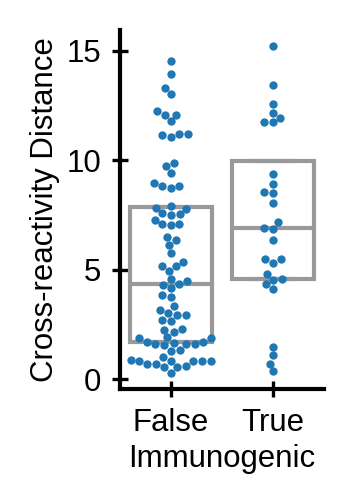

In [43]:
fig, ax = plt.subplots(figsize=(1.25, 1.75))
sns.swarmplot(data=d1, x='Immunogenic', y='distance', ax=ax, s=2)
sns.boxplot(data=d1, x='Immunogenic', y='distance', color='white', showfliers=False, whis=0, ax=ax)
ax.set_ylabel('Cross-reactivity Distance')
fig.tight_layout()
# fig.savefig(figuredir+'iedb_crossreactivity_distance.svg')

In [46]:
d1.to_csv('../../figures/New Paper Figures/Figure Data/epidist.csv')


In [36]:
(scipy.stats.mannwhitneyu(d1[d1['Immunogenic']==1.0]['distance'],
                          d1[d1['Immunogenic']==0.0]['distance']),
 scipy.stats.ttest_ind(d1[d1['Immunogenic']==1.0]['distance'], d1[d1['Immunogenic']==0.0]['distance']))


(MannwhitneyuResult(statistic=810.5, pvalue=0.018271857983545133),
 Ttest_indResult(statistic=2.1544641064211216, pvalue=0.03349014936655385))

In [37]:
d1['d<c'] = d1['distance']<2.0
ps = d1.groupby('d<c').agg('mean')['Immunogenic']
ns = d1.groupby('d<c').agg('count')['Immunogenic']
npos = ns*ps
test = statsmodels.stats.proportion.proportions_chisquare(npos, ns)
test[1], ps

(0.07577249500030649,
 d<c
 False    0.307692
 True     0.137931
 Name: Immunogenic, dtype: float64)

# Neighbor distance <=2

In [38]:
df_d2 = d[d['nndist']==2].copy()

In [39]:
epitopes = list(df_d2['Epitope', 'Description'])

In [40]:
neighbors = []
neighbor_numbers = []
diffposs = []
for epitope in epitopes:
    all_neighbors = set(next_nearest_neighbors(epitope, hamming_neighbors, maxdistance=2)).intersection(selfset)
    neighbor = random.choice(list(all_neighbors))
    diff = np.array(list(epitope)) != np.array(list(neighbor))
    diffpos = list(diff.nonzero()[0])
    diffposs.append(diffpos)
    neighbors.append(neighbor)
    neighbor_numbers.append(len(all_neighbors))
    #print(epitope,
    #      neighbor,
    #      len(all_neighbors),
    #      diffpos)
neighbor_numbers = np.array(neighbor_numbers)
neighbors = np.array(neighbors)
diffposs = np.array(diffposs)

Text(0.5, 0, 'Frequency')

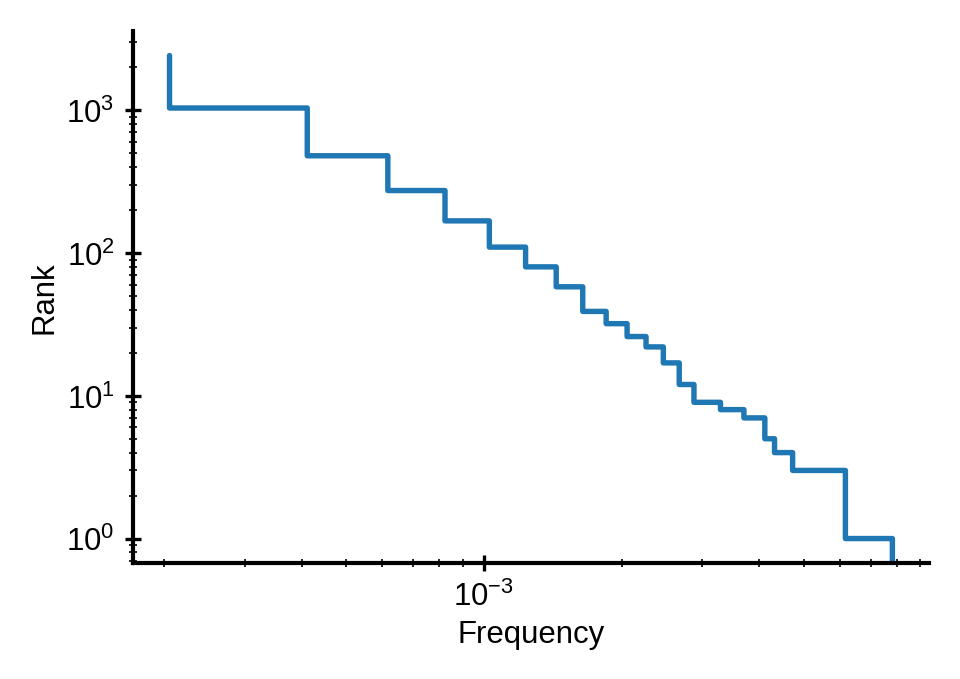

In [41]:
fig, ax = plt.subplots()
pp.rankfrequency(neighbor_numbers, ax=ax)
ax.set_ylabel('Rank')
ax.set_xlabel('Frequency')

In [42]:
df_d2['Anchor'] = np.isin(diffposs[:, 0], anchors).astype(int) + np.isin(diffposs[:, 1], anchors)
df_d2['Neighbors'] = neighbor_numbers>1.0

Anchor
0    0.265167
1    0.236220
2    0.370968
Name: (Assay, Positive), dtype: float64 Anchor
0    1467
1     889
2      62
Name: (Assay, Positive), dtype: int64


/home/andreas/mambaforge/envs/peptidome/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Text(0, 0.5, 'Fraction immunogenic')

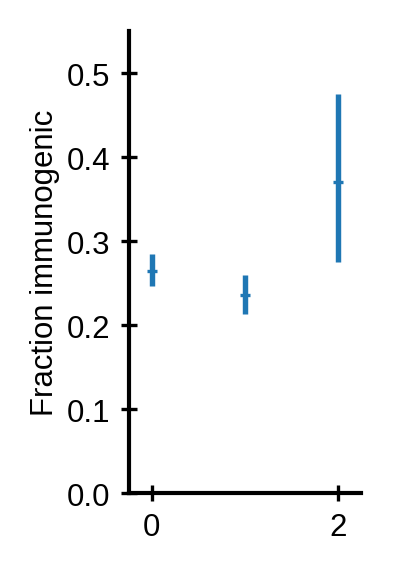

In [43]:
ps = df_d2.groupby('Anchor').agg('mean')['Assay', 'Positive']
ns = df_d2.groupby('Anchor').agg('count')['Assay', 'Positive']
print(ps, ns)
npos = ns*ps
lower, upper = statsmodels.stats.proportion.proportion_confint(npos, ns, method='jeffreys', alpha=.1)
fig, ax = plt.subplots(figsize=(1.0, 2))
ax.errorbar(ps.index, ps, yerr=[ps-lower, upper-ps], ls='None', fmt='_')
ax.set_ylim(0, 0.55)
ax.set_xlim(-0.25, 2.25)
ax.set_ylabel('Fraction immunogenic')

In [44]:
pairs = list(zip(epitopes, neighbors))

In [45]:
distance = np.array([epd.epitope_dist(epiA, epiB) for epiA, epiB in pairs])

In [46]:
df_d2.columns = df_d2.columns.droplevel(1)

In [47]:
df_d2['distance'] = distance

(MannwhitneyuResult(statistic=555147.0, pvalue=0.41015865915572997),
 Ttest_indResult(statistic=-0.007629124348104337, pvalue=0.9939135283844771))

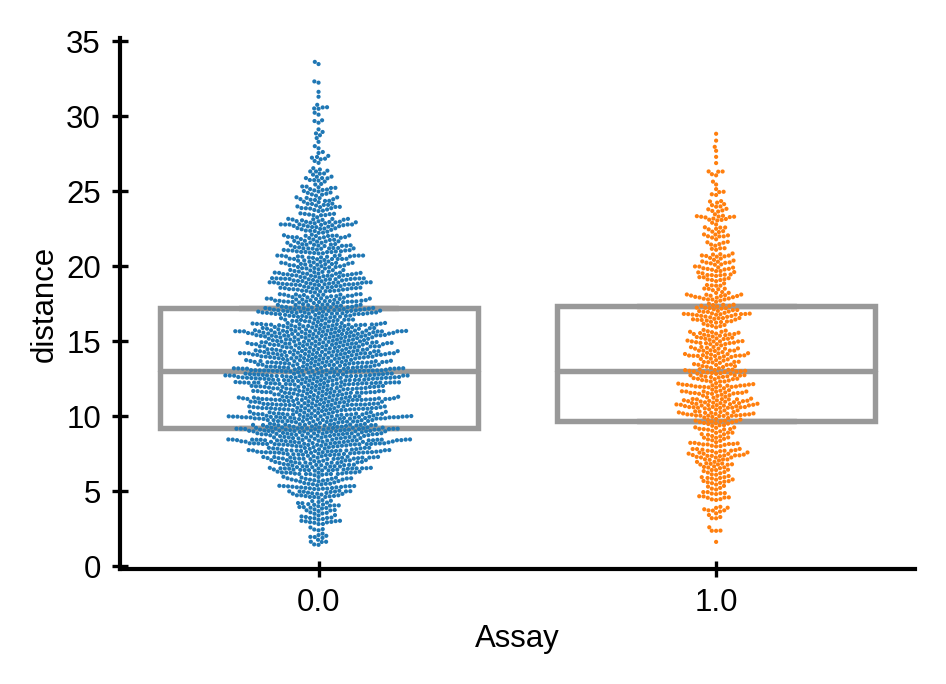

In [48]:
sns.swarmplot(data=df_d2, x='Assay', y='distance', size=1)
sns.boxplot(data=df_d2, x='Assay', y='distance', color='white', showfliers=False, whis=0)
(scipy.stats.mannwhitneyu(df_d2[df_d2['Assay']==1.0]['distance'],
                          df_d2[df_d2['Assay']==0.0]['distance']),
 scipy.stats.ttest_ind(df_d2[df_d2['Assay']==1.0]['distance'],
                       df_d2[df_d2['Assay']==0.0]['distance']))

In [13]:
import os
import pandas as pd

In [30]:
peptides = pd.read_csv('../maxent/data/netMHC_input/net_mhc_input_example_epitopes.txt',header=None)[0]
binders = {p: [] for p in peptides}

In [31]:
files = [f for f in os.listdir('../maxent/data/netMHC_output') if "example_epitopes" in f]
for fi in files:
    results = pd.read_csv(f'../maxent/data/netMHC_output/{fi}')
    allele = fi.split('net_mhc_output_example_epitopes')[-1].removesuffix('.csv').removeprefix('-')
    for peptide in list(results['Peptide']):
        binders[peptide].append(allele)

In [32]:
binders

{'GAAGGLALL': ['HLA-C0303', 'HLA-B4801'],
 'GIAGGLALL': ['HLA-A0202', 'HLA-A0250', 'HLA-A0203'],
 'VLAGLLGMV': ['HLA-A0211',
  'HLA-A0212',
  'HLA-A0219',
  'HLA-A0216',
  'HLA-A0202',
  'HLA-A0250',
  'HLA-A0203'],
 'VLAGLLGNV': ['HLA-A0211',
  'HLA-A0212',
  'HLA-A0219',
  'HLA-A0216',
  'HLA-A0202',
  'HLA-A0250',
  'HLA-A0203',
  'HLA-A0205'],
 'LGILSVSSF': ['HLA-B1503'],
 'LAILSVSSF': ['HLA-B3501',
  'HLA-B1501',
  'HLA-B1517',
  'HLA-B4601',
  'HLA-B1503'],
 'AKLDNLDEE': [],
 'AKLDRLDEE': [],
 'GLGAAVVAV': ['HLA-A0211',
  'HLA-A0212',
  'HLA-A0219',
  'HLA-A0216',
  'HLA-A0202',
  'HLA-A0203',
  'HLA-A0205'],
 'GLAAAVVAV': ['HLA-A0211',
  'HLA-A0212',
  'HLA-A0219',
  'HLA-A0201',
  'HLA-A0216',
  'HLA-A0202',
  'HLA-A0203',
  'HLA-A0206',
  'HLA-A0205'],
 'RLLDRLVRR': ['HLA-A3101'],
 'RLLDRLVRL': ['HLA-A0211',
  'HLA-A0219',
  'HLA-A0201',
  'HLA-C0401',
  'HLA-B4801',
  'HLA-A0206'],
 'APVVPPEPL': ['HLA-B0702', 'HLA-B4201', 'HLA-B8301', 'HLA-B3503'],
 'APVPPPEPL': ['HLA-C0303',